In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [11]:
df_modelos = pd.read_csv("../data/datosFinales/df_modelos.csv", sep = ";")
#dropped columns which are 0
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('diferencia_1')]
categoricas = pd.read_csv("../data/categoricas.csv", sep = ",").squeeze().tolist()
print(len(categoricas))
#remove columns with many NAs
categoricas.remove('tipo_plastia')
categoricas.remove('via_asc_plastia')
print(len(categoricas))

30
28


In [12]:
df_modelos

,id_registro,sexo,edad,peso,talla,imc,neoadyuvancia,localizacion,tipo_histologico,ct,...,temp_corp_diferencia_5,pcr_diferencia_5,plaquetas_diferencia_5,leucocitos_diferencia_5,tad_diferencia_5,tas_diferencia_5,creatinina_diferencia_5,frec_resp_diferencia_5,eva_diferencia_5,frec_card_diferencia_5
0,92-1,0.0,61.0,79.0,178.0,24.9,1.0,4.0,1.0,4.0,...,-0.1,115.80,0.005666,-0.766582,-15.0,-30.0,-0.03,-1.0,-3.0,NaN
1,92-2,1.0,79.0,95.0,170.0,32.9,0.0,4.0,1.0,2.0,...,-0.6,59.60,0.298043,-0.143161,NaN,22.0,-0.48,-6.0,-4.0,23.0
2,92-3,0.0,74.0,94.0,175.0,30.7,1.0,4.0,NaN,4.0,...,-0.2,177.00,0.032002,-0.180880,12.0,16.0,0.02,1.0,3.0,17.0
3,92-4,0.0,74.0,63.0,168.0,22.3,2.0,3.0,1.0,5.0,...,1.1,NaN,NaN,NaN,-15.0,-11.0,NaN,8.0,4.0,32.0
4,92-5,0.0,62.0,57.0,157.0,23.1,2.0,4.0,1.0,4.0,...,-0.5,121.40,0.145181,0.768582,6.0,12.0,-0.23,2.0,-5.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,613-30,0.0,72.0,83.0,169.0,29.1,1.0,3.0,1.0,3.0,...,0.0,27.00,0.090728,0.291415,-29.0,-19.0,-0.06,3.0,-1.0,14.0
724,613-31,1.0,40.0,58.0,160.0,22.7,0.0,5.0,1.0,3.0,...,-0.3,11.62,0.226184,-0.796733,-13.0,-13.0,-0.17,0.0,-1.0,-11.0
725,613-32,0.0,59.0,82.0,171.0,28.0,1.0,7.0,1.0,2.0,...,-1.7,-3.09,0.454254,-0.577630,-12.0,-11.0,-0.02,-6.0,-2.0,-32.0
726,617-1,0.0,74.0,53.0,160.0,20.7,0.0,6.0,2.0,2.0,...,-0.1,40.00,0.213257,-0.660411,-11.0,-24.0,0.17,-2.0,-3.0,-16.0


In [13]:
idPats = np.unique(df_modelos.id_registro)

df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_5')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_4')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_3')]
#df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_2')]

# Modelo Xgboost


In [14]:
np.random.seed(14)

In [15]:
df_tmp = df_modelos.copy()[df_modelos['fuga'] != -1]
cats = []

columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)

y = df_tmp['fuga']

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [17]:
# # ------------------------------
# # 2. Imputación LOCF + NOCB
# # ------------------------------

# X_imputed = X.copy()

# # Extraer variable base de cada columna (por ejemplo 'v1' de 'v1_0')
# col_grupos = {}
# for col in X.columns:
#     base = col.split('_')[0]
#     col_grupos.setdefault(base, []).append(col)

# # Aplicar LOCF y luego NOCB por fila, dentro de cada grupo de variable
# for base_var, cols in col_grupos.items():
#     X_imputed[cols] = X[cols].ffill(axis=1).bfill(axis=1)

# # ------------------------------
# # 3. Imputación final si quedan nulos
# # ------------------------------

# X_final = X_imputed.fillna(X_imputed.mean())

# # ------------------------------
# # 4. Entrenamiento con XGBoost
# # ------------------------------

# pipeline = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
# ])

# scores = cross_val_score(pipeline, X_final, y, cv=5, scoring="roc_auc")
# print(f"AUC promedio con LOCF + NOCB (5-CV): {scores.mean():.3f}")

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=14)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=14)

In [19]:
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'error'],
    'max_depth': 4,  # Reducida desde 5
    'learning_rate': 0.001,  # Reducida desde 0.05
    'subsample': 0.3,  # Más bajo para más regularización
    'colsample_bytree': 0.7,
    'min_child_weight': 5,  # Aumentada desde 3
    'gamma': 0.3,  # Aumentada desde 0.2
    'reg_alpha': 2,  # Aumentada desde 1
    'reg_lambda': 15,  # Aumentada desde 10
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1]) * 1.2,  # Balance ajustado
    'seed': 14,
    'tree_method': 'hist'
}


In [20]:

# Encode categorical variables in X_train and X_val
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Convertir a DMatrix

dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded)


#evals_result = {}
model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,  # Más iteraciones posibles
    verbose_eval=50
)



In [21]:
from sklearn.metrics import f1_score, accuracy_score

In [22]:
y_proba_train = model.predict(dtrain)
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TRAIN:
[[317  65]
 [ 11  81]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       382
           1       0.55      0.88      0.68        92

    accuracy                           0.84       474
   macro avg       0.76      0.86      0.79       474
weighted avg       0.89      0.84      0.85       474

Accuracy: 0.8396624472573839
AUC: 0.8551
F1 score: 0.680672268907563


In [23]:

y_proba_test = model.predict(dtest)
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TEST:
[[117  48]
 [ 15  24]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       165
           1       0.33      0.62      0.43        39

    accuracy                           0.69       204
   macro avg       0.61      0.66      0.61       204
weighted avg       0.78      0.69      0.72       204

Accuracy: 0.6911764705882353
AUC: 0.7408
F1 score: 0.43243243243243246


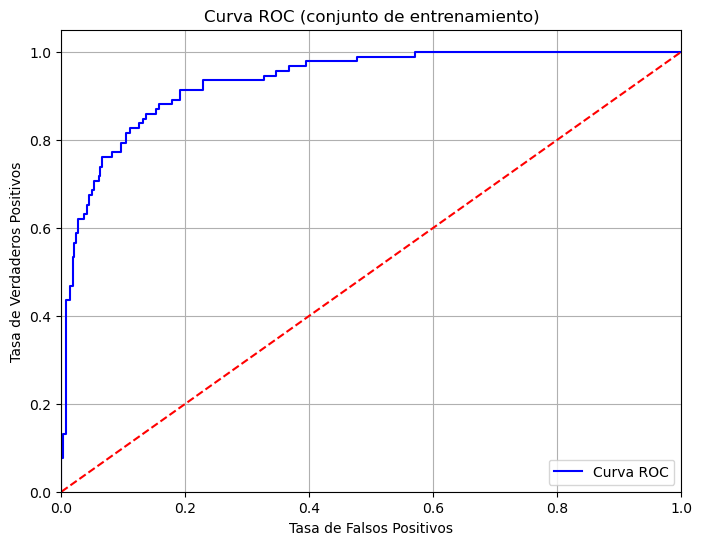

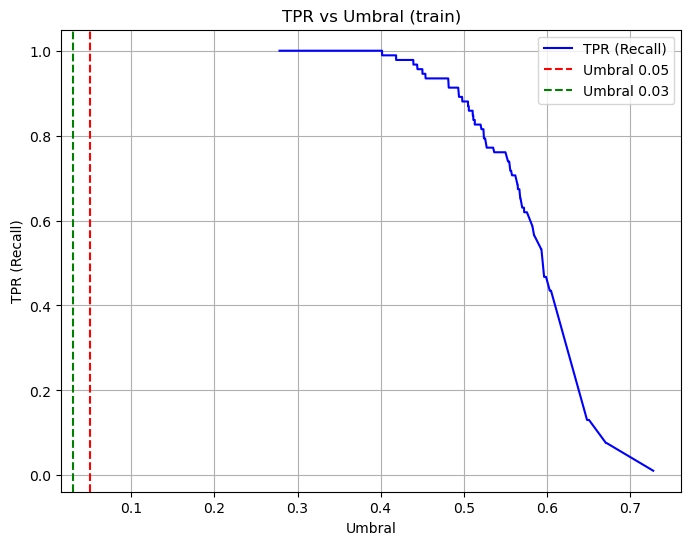

In [24]:
#show the roc curve for the model "modelo_hgb"
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_proba_train, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el tpr vs el umbral para train
plt.figure(figsize=(8, 6))
plt.plot(thresholds_train, tpr_train, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral (train)')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()




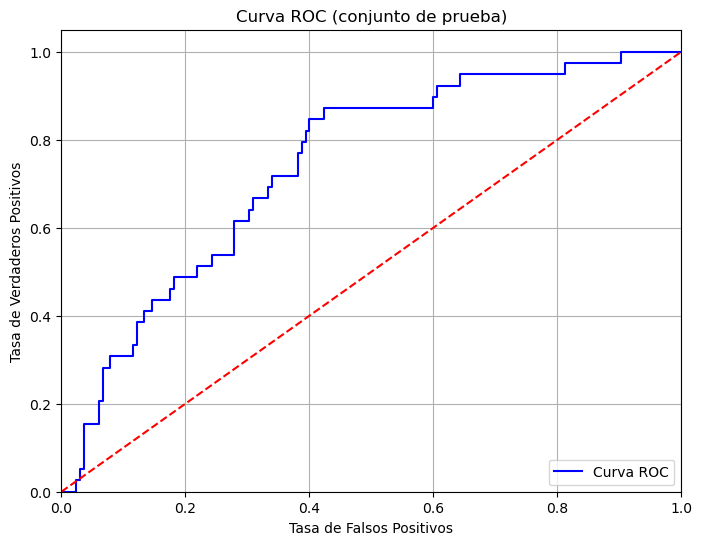

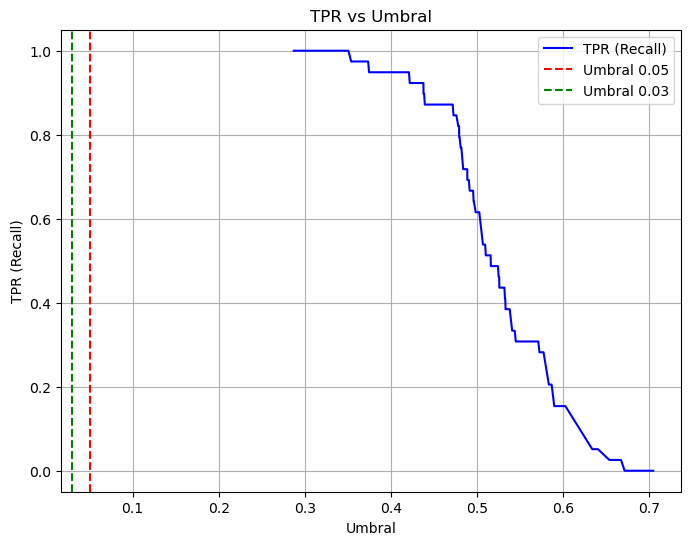

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()



In [26]:

exp = dx.Explainer(model, X, y)
vi = exp.model_parts() #MIRAR EL METODO!!!
vi.plot(max_vars=20)
#select the 10 most important variables from the explainer
imps = vi.result['variable'][-30:-1].tolist()
imps.append('id_registro')

Preparation of a new explainer is initiated

  -> data              : 678 rows 122 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x140d70700> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.278, mean = 0.459, max = 0.728
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.704, mean = -0.266, max = 0.65
  -> model_info        : package xgboost

A new explainer has been created!


In [27]:
print("[")
for i in imps:
    print(",", i)

[
, frec_resp_2
, leucocitos_diferencia_2
, pcr_diferencia_0
, quick_diferencia_2
, plaquetas_diferencia_2
, proteinas_2
, tas_1
, tas_diferencia_0
, neutrofilos_2
, quick_2
, leucocitos_diferencia_0
, proteinas_0
, il6_diferencia_0
, quick_1
, temp_corp_1
, perdida_sang
, il6_2
, il6_diferencia_2
, neutrofilos_diferencia_2
, linfocitos_1
, pcr_1
, neutrofilos_diferencia_0
, linfocitos_2
, pcr_0
, tipo_cirugia
, pcr_2
, pcr_diferencia_2
, frec_card_1
, localizacion
, id_registro


In [28]:
df_imps = df_modelos[imps]
df_imps['fuga'] = df_modelos['fuga']
df_imps['id_registro'] = df_modelos['id_registro']

In [29]:
df_tmp = df_imps.copy()[df_imps['fuga'] != -1]
cats = []
    
columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)
y = df_tmp['fuga']



In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=14)


In [43]:
# for col in cats:
#     if col in X.columns:
#         label_encoder = LabelEncoder()  
#         label_encoder.fit(X[col]) 
#         X[col] = label_encoder.transform(X[col])

# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, 
#     test_size=0.3, 
#     stratify=y, 
#     random_state=14
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_trainval, y_trainval, 
#     test_size=0.2, 
#     stratify=y_trainval, 
#     random_state=14
# )

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# Espacio de búsqueda basado en tus best_params
param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': uniform(0.5, 10),
}

# Codificación de variables categóricas (ya la tienes lista)
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
# Aplica aquí tu codificación si hace falta

# Modelo base
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    seed=14,
    tree_method='hist'
)

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=14,
)

# Entrenamiento
random_search.fit(X_train_encoded, y_train)

# Mejor modelo
best_model = random_search.best_estimator_

# Predicción (si quieres seguir luego con predicciones o evaluación)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [45]:
from sklearn.metrics import f1_score, accuracy_score

In [46]:
y_proba_train = best_model.predict_proba(X_train_encoded)[:, 1]
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_proba_train)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TRAIN:
[[375   7]
 [  0  92]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       382
           1       0.93      1.00      0.96        92

    accuracy                           0.99       474
   macro avg       0.96      0.99      0.98       474
weighted avg       0.99      0.99      0.99       474

AUC: 1.0000
Accuracy: 0.9852320675105485
F1 score: 0.9633507853403142


In [47]:
y_proba_test = best_model.predict_proba(X_test_encoded)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print(f"\nAUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1)



=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TEST:
[[138  27]
 [ 23  16]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       165
           1       0.37      0.41      0.39        39

    accuracy                           0.75       204
   macro avg       0.61      0.62      0.62       204
weighted avg       0.76      0.75      0.76       204


AUC: 0.7500
Accuracy: 0.7549019607843137
F1 score: 0.3902439024390244


0.9411

0.7333

In [36]:
exp = dx.Explainer(best_model, X, y)
vi = exp.model_parts(max_vars=30)
vi.plot(max_vars=20)


Preparation of a new explainer is initiated

  -> data              : 678 rows 29 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x140d70670> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00521, mean = 0.282, max = 0.988
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.948, mean = -0.0887, max = 0.931
  -> model_info        : package xgboost

A new explainer has been created!


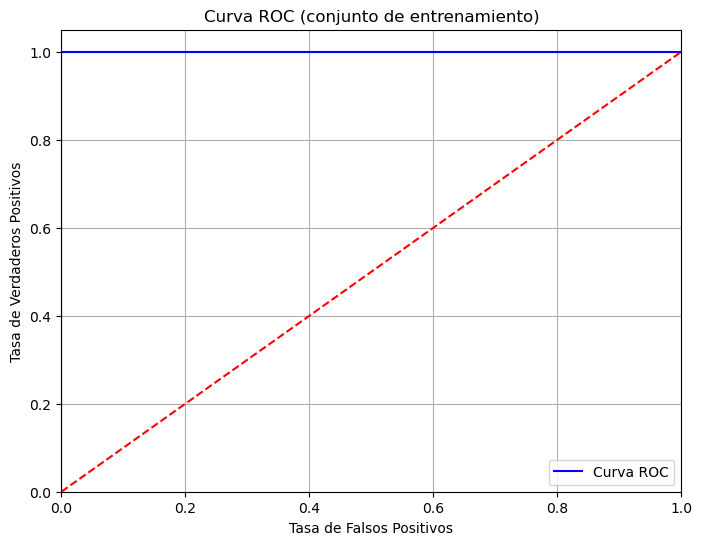

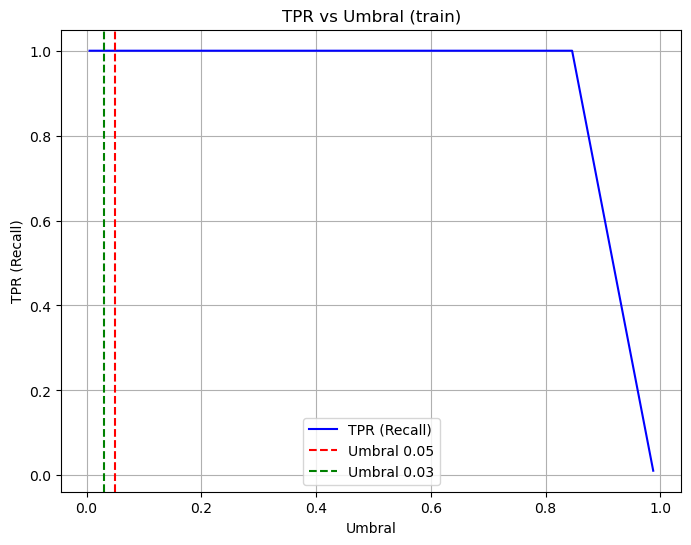

In [48]:
#show the roc curve for the model "modelo_hgb"
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_proba_train, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el tpr vs el umbral para train
plt.figure(figsize=(8, 6))
plt.plot(thresholds_train, tpr_train, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral (train)')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()




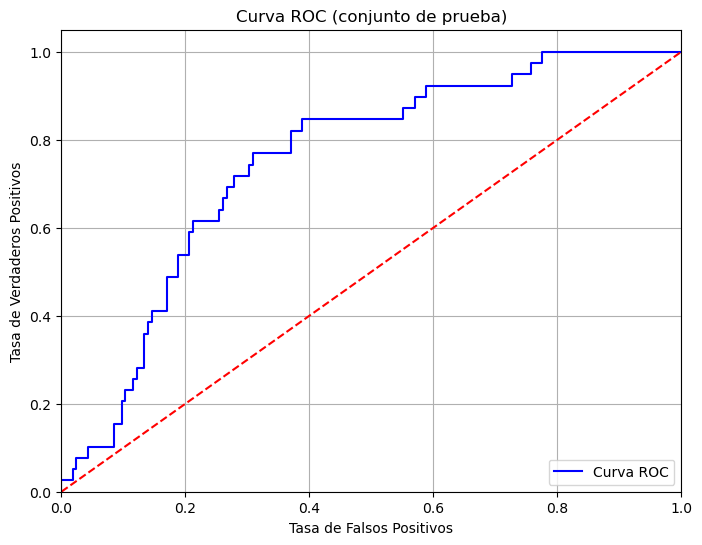

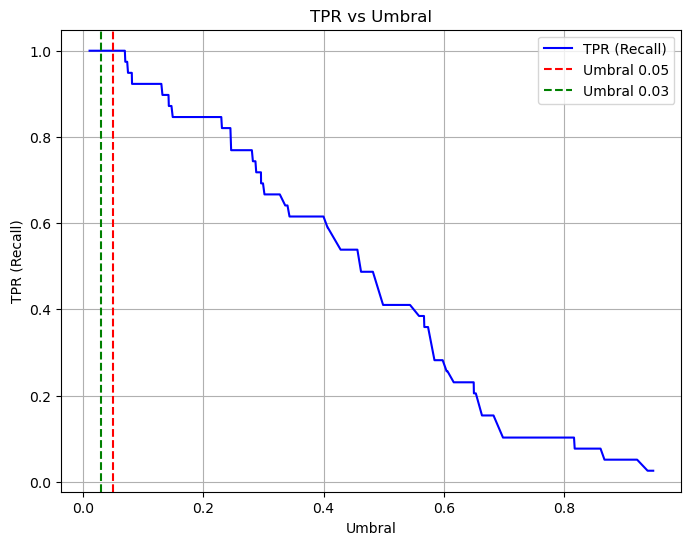

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()



In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,
    n_estimators=100
)

rf.fit(X_train, y_train)

ensemble_pred = (0.7*y_proba_test + 0.3*rf.predict_proba(X_test)[:,1]) > 0.39
y_pred_ensemble = ensemble_pred.astype(int)

# Generar reporte de clasificación completo
print("\n=== RESULTADOS DEL ENSEMBLE ===")
print("Matriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_ensemble))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_ensemble, zero_division=0))
print(f"AUC-ROC Ensemble: {roc_auc_score(y_test, 0.7*y_proba_test + 0.3*rf.predict_proba(X_test)[:,1]):.4f}")


=== RESULTADOS DEL ENSEMBLE ===
Matriz de confusión TEST:
[[130  35]
 [ 15  24]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       165
           1       0.41      0.62      0.49        39

    accuracy                           0.75       204
   macro avg       0.65      0.70      0.66       204
weighted avg       0.80      0.75      0.77       204

AUC-ROC Ensemble: 0.7593


In [40]:
#0.7378
#0.7409

